# Cross-validation
Cross-validation is used to estimate the error in unknown new datasets.

Stratified cross-validation uses the same distribution of classes for the training and test sets.

## Stratified versus non-stratified
  1. What is the issue with NOT using cross-validation?
  2. Why is the difference between stratified and regular cross-validation?
  3. When is stratified cross-validation required?
  
## Model parameter tuning
  4. What are the optimal parameters obtained for the different methods? 
  5. What is the estimated accuracy for the different approaches? 
  
## Nested cross-validation
  6. What is the advantage of using nested cross-validation over other methods?
  7. What is the problem with using the fully nested approach to estimate everything?
  8. How do we get 900 models fitted for nested cross-validation?
  
## Big Datasets
  9. What is the best approach for big datasets?
  10. What are we missing from using this approach?
  
The example is taken from Chapter 5 of an Introduction to Machine Learning with Python
[Github for book code](https://github.com/amueller/introduction_to_ml_with_python)

In [3]:
from sklearn.datasets import load_iris
iris = load_iris()

print("\n Data Description:\n")
print("X: flower measurements:\n{}".format(iris.feature_names))
print("y: flower names:\n{}".format(iris.target_names))

X = iris.data
y = iris.target

print("\n Data sizes:\n")
print('X has {} observations of {}-dimensional vectors'.format(X.shape[0], X.shape[1]))
print('y has {} responses.'.format(y.shape[0]))

print("\n Looking into the data:\n")
print("X: first five measurements:\n{}".format(X[0:5]))
print("Y: all labels:\n{}".format(iris.target))


 Data Description:

X: flower measurements:
['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
y: flower names:
['setosa' 'versicolor' 'virginica']

 Data sizes:

X has 150 observations of 4-dimensional vectors
y has 150 responses.

 Looking into the data:

X: first five measurements:
[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]]
Y: all labels:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


## Inaccurate Model Performance Measurement and Tuning Without CV

In [4]:
# naive grid search implementation
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

# Randomly sample a train set and test set:
X_train, X_test, y_train, y_test = train_test_split(
    iris.data, iris.target, random_state=0)

print("Size of training set: {}   size of test set: {}".format(
      X_train.shape[0], X_test.shape[0]))

# Naive optimization
best_score = 0

for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        # for each combination of parameters, train an SVC
        svm = SVC(gamma=gamma, C=C)
        svm.fit(X_train, y_train)
        # evaluate the SVC on the test set
        score = svm.score(X_test, y_test)
        # if we got a better score, store the score and parameters
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}

print("Best score: {:.2f}".format(best_score))
print("Best parameters: {}".format(best_parameters))
print("Why is this result incorrect?")

Size of training set: 112   size of test set: 38
Best score: 0.97
Best parameters: {'C': 100, 'gamma': 0.001}
Why is this result incorrect?


# Training, validation, and test sets

## Single split into one training set, one validation set, one test set

In [5]:
from sklearn.svm import SVC
# split data into train+validation set and test set
X_trainval, X_test, y_trainval, y_test = train_test_split(
    iris.data, iris.target, random_state=0)

# split train+validation set into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(
    X_trainval, y_trainval, random_state=1)
print("Size of training set: {}   size of validation set: {}   size of test set:"
      " {}\n".format(X_train.shape[0], X_valid.shape[0], X_test.shape[0]))

best_score = 0

for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        # for each combination of parameters, train an SVC
        svm = SVC(gamma=gamma, C=C)
        svm.fit(X_train, y_train)
        
        # evaluate the SVC on the validation set
        score = svm.score(X_valid, y_valid)
        # if we got a better score, store the score and parameters
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}

# rebuild a model on the combined training and validation set,
# and evaluate it on the test set
svm = SVC(**best_parameters)
svm.fit(X_trainval, y_trainval)
test_score = svm.score(X_test, y_test)
print("Best score on validation set: {:.2f}".format(best_score))
print("Best parameters: ", best_parameters)
print("Test set score with best parameters: {:.2f}".format(test_score))

Size of training set: 84   size of validation set: 28   size of test set: 38

Best score on validation set: 0.96
Best parameters:  {'C': 10, 'gamma': 0.001}
Test set score with best parameters: 0.92


## Cross-validation

In [6]:
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression

iris = load_iris()
logreg = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=1000)

scores = cross_val_score(logreg, iris.data, iris.target, cv=5)
print("Cross-validation scores: {}".format(scores))

Cross-validation scores: [0.96666667 1.         0.93333333 0.96666667 1.        ]


## Cross-validation for each parameter set

In [7]:
import numpy as np

for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        # for each combination of parameters,
        # train an SVC
        svm = SVC(gamma=gamma, C=C)
        # perform cross-validation
        scores = cross_val_score(svm, X_trainval, y_trainval, cv=5)
        # compute mean cross-validation accuracy
        score = np.mean(scores)
        # if we got a better score, store the score and parameters
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}

print(best_parameters)

# rebuild a model on the combined training and validation set
svm = SVC(**best_parameters)
svm.fit(X_trainval, y_trainval)

{'C': 100, 'gamma': 0.01}


SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

## Cross-validation using GridSearchCV

In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

# Parameters
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
print("Parameter grid:\n{}".format(param_grid))

# Create Grid search cross-validation
grid_search = GridSearchCV(SVC(), param_grid, cv=5,
                          return_train_score=True)

# Break into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    iris.data, iris.target, random_state=0)

# Apply cross-validation over the training set
grid_search.fit(X_train, y_train)

# Print the results
print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))
print("Best estimator:\n{}".format(grid_search.best_estimator_))

# Measure the error on the test set:
print("Test set score: {:.2f}".format(grid_search.score(X_test, y_test)))

Parameter grid:
{'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
Best parameters: {'C': 100, 'gamma': 0.01}
Best cross-validation score: 0.97
Best estimator:
SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
Test set score: 0.97


/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [9]:
import pandas as pd

# convert to DataFrame
results = pd.DataFrame(grid_search.cv_results_)
print(results)


    mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
0        0.001179      0.000614         0.000583        0.000157   0.001   
1        0.000824      0.000014         0.000458        0.000097   0.001   
2        0.000916      0.000156         0.000443        0.000041   0.001   
3        0.000893      0.000057         0.000478        0.000106   0.001   
4        0.001012      0.000104         0.000636        0.000227   0.001   
5        0.001243      0.000333         0.000630        0.000332   0.001   
6        0.001034      0.000289         0.000532        0.000250    0.01   
7        0.000827      0.000078         0.000509        0.000264    0.01   
8        0.000801      0.000156         0.000440        0.000082    0.01   
9        0.000720      0.000053         0.000371        0.000084    0.01   
10       0.000733      0.000009         0.000336        0.000019    0.01   
11       0.000863      0.000087         0.000350        0.000030    0.01   
12       0.0

[[0.36607143 0.36607143 0.36607143 0.36607143 0.36607143 0.36607143]
 [0.36607143 0.36607143 0.36607143 0.36607143 0.36607143 0.36607143]
 [0.36607143 0.69642857 0.91964286 0.95535714 0.36607143 0.36607143]
 [0.69642857 0.92857143 0.96428571 0.94642857 0.91964286 0.50892857]
 [0.92857143 0.96428571 0.96428571 0.9375     0.91964286 0.57142857]
 [0.96428571 0.97321429 0.95535714 0.94642857 0.91964286 0.57142857]]


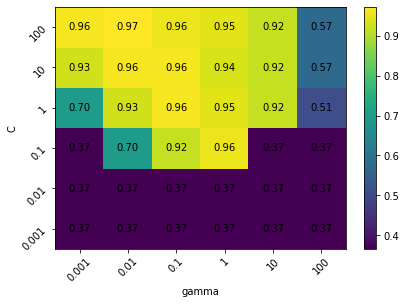

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

scores = np.array(results.mean_test_score).reshape(6, 6)
print(scores)


heatmap = plt.pcolor(scores)
for y in range(scores.shape[0]):
    for x in range(scores.shape[1]):
        plt.text(x + 0.5, y + 0.5, '%.2f' % scores[y, x],
                horizontalalignment='center',
                verticalalignment='center',)


#plt.grid() #this will look bad now
plt.colorbar(heatmap)
plt.subplots_adjust(left=0.15, right=0.99, bottom=0.15, top=0.99)
plt.ylabel('C')
plt.xlabel('gamma')

gamma_range = param_grid['gamma']
C_range     = param_grid['C']
plt.xticks(np.arange(len(gamma_range))+0.5, gamma_range, rotation=45,)
plt.yticks(np.arange(len(C_range))+0.5, C_range, rotation=45)
plt.show()

## Nested Cross-Validation
This approach allows us to estimate the error in the final classifier.
Note that stratified sampling is used.

In [13]:
# Single line implementation of Nested Cross-validation
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
scores = cross_val_score(GridSearchCV(SVC(), param_grid, cv=5),
                         iris.data, iris.target, cv=5)
print("Cross-validation scores: ", scores)

# Print a list of stats
stats_list = (scores.min(), scores.max(), scores.mean())
print("Min value = {:0.2f}, Max value = {:0.2f}, Mean = {:0.2f}".format(*stats_list))

Cross-validation scores:  [0.96666667 1.         0.96666667 0.96666667 1.        ]
Min value = 0.97, Max value = 1.00, Mean = 0.98


In [16]:
# Flexible Nested Cross-validation that helps visualize what 
# is happening. See next cell for how to call it.
def nested_cv(X, y, inner_cv, outer_cv, Classifier, parameter_grid):
    outer_scores = []
    
    # for each split of the data in the outer cross-validation
    # (split method returns indices of training and test parts)
    for training_samples, test_samples in outer_cv.split(X, y):
        # find best parameter using inner cross-validation
        best_parms = {}
        best_score = -np.inf
        # iterate over parameters
        for parameters in parameter_grid:
            # accumulate score over inner splits
            cv_scores = []
            # iterate over inner cross-validation
            for inner_train, inner_test in inner_cv.split(
                    X[training_samples], y[training_samples]):
                # build classifier given parameters and training data
                print("Params: " + str(parameters))
                clf = Classifier(**parameters)
                clf.fit(X[inner_train], y[inner_train])
                # evaluate on inner test set
                score = clf.score(X[inner_test], y[inner_test])
                cv_scores.append(score)
            # compute mean score over inner folds
            mean_score = np.mean(cv_scores)
            if mean_score > best_score:
                # if better than so far, remember parameters
                best_score = mean_score
                best_params = parameters
        # build classifier on best parameters using outer training set
        clf = Classifier(**best_params)
        clf.fit(X[training_samples], y[training_samples])
        # evaluate
        outer_scores.append(clf.score(X[test_samples], y[test_samples]))
    return np.array(outer_scores)

In [17]:
from sklearn.model_selection import ParameterGrid, StratifiedKFold

scores = nested_cv(iris.data, iris.target, StratifiedKFold(5),
                   StratifiedKFold(5), SVC, ParameterGrid(param_grid))
print("Cross-validation scores: {}".format(scores))

# Print a list of stats
stats_list = (scores.min(), scores.max(), scores.mean())
print("Min value = {:0.2f}, Max value = {:0.2f}, Mean = {:0.2f}".format(*stats_list))

Params: {'C': 0.001, 'gamma': 0.001}
Params: {'C': 0.001, 'gamma': 0.001}
Params: {'C': 0.001, 'gamma': 0.001}
Params: {'C': 0.001, 'gamma': 0.001}
Params: {'C': 0.001, 'gamma': 0.001}
Params: {'C': 0.001, 'gamma': 0.01}
Params: {'C': 0.001, 'gamma': 0.01}
Params: {'C': 0.001, 'gamma': 0.01}
Params: {'C': 0.001, 'gamma': 0.01}
Params: {'C': 0.001, 'gamma': 0.01}
Params: {'C': 0.001, 'gamma': 0.1}
Params: {'C': 0.001, 'gamma': 0.1}
Params: {'C': 0.001, 'gamma': 0.1}
Params: {'C': 0.001, 'gamma': 0.1}
Params: {'C': 0.001, 'gamma': 0.1}
Params: {'C': 0.001, 'gamma': 1}
Params: {'C': 0.001, 'gamma': 1}
Params: {'C': 0.001, 'gamma': 1}
Params: {'C': 0.001, 'gamma': 1}
Params: {'C': 0.001, 'gamma': 1}
Params: {'C': 0.001, 'gamma': 10}
Params: {'C': 0.001, 'gamma': 10}
Params: {'C': 0.001, 'gamma': 10}
Params: {'C': 0.001, 'gamma': 10}
Params: {'C': 0.001, 'gamma': 10}
Params: {'C': 0.001, 'gamma': 100}
Params: {'C': 0.001, 'gamma': 100}
Params: {'C': 0.001, 'gamma': 100}
Params: {'C': 0.001,

Params: {'C': 0.1, 'gamma': 10}
Params: {'C': 0.1, 'gamma': 10}
Params: {'C': 0.1, 'gamma': 10}
Params: {'C': 0.1, 'gamma': 10}
Params: {'C': 0.1, 'gamma': 10}
Params: {'C': 0.1, 'gamma': 100}
Params: {'C': 0.1, 'gamma': 100}
Params: {'C': 0.1, 'gamma': 100}
Params: {'C': 0.1, 'gamma': 100}
Params: {'C': 0.1, 'gamma': 100}
Params: {'C': 1, 'gamma': 0.001}
Params: {'C': 1, 'gamma': 0.001}
Params: {'C': 1, 'gamma': 0.001}
Params: {'C': 1, 'gamma': 0.001}
Params: {'C': 1, 'gamma': 0.001}
Params: {'C': 1, 'gamma': 0.01}
Params: {'C': 1, 'gamma': 0.01}
Params: {'C': 1, 'gamma': 0.01}
Params: {'C': 1, 'gamma': 0.01}
Params: {'C': 1, 'gamma': 0.01}
Params: {'C': 1, 'gamma': 0.1}
Params: {'C': 1, 'gamma': 0.1}
Params: {'C': 1, 'gamma': 0.1}
Params: {'C': 1, 'gamma': 0.1}
Params: {'C': 1, 'gamma': 0.1}
Params: {'C': 1, 'gamma': 1}
Params: {'C': 1, 'gamma': 1}
Params: {'C': 1, 'gamma': 1}
Params: {'C': 1, 'gamma': 1}
Params: {'C': 1, 'gamma': 1}
Params: {'C': 1, 'gamma': 10}
Params: {'C': 1, 'ga

Params: {'C': 0.001, 'gamma': 10}
Params: {'C': 0.001, 'gamma': 10}
Params: {'C': 0.001, 'gamma': 10}
Params: {'C': 0.001, 'gamma': 100}
Params: {'C': 0.001, 'gamma': 100}
Params: {'C': 0.001, 'gamma': 100}
Params: {'C': 0.001, 'gamma': 100}
Params: {'C': 0.001, 'gamma': 100}
Params: {'C': 0.01, 'gamma': 0.001}
Params: {'C': 0.01, 'gamma': 0.001}
Params: {'C': 0.01, 'gamma': 0.001}
Params: {'C': 0.01, 'gamma': 0.001}
Params: {'C': 0.01, 'gamma': 0.001}
Params: {'C': 0.01, 'gamma': 0.01}
Params: {'C': 0.01, 'gamma': 0.01}
Params: {'C': 0.01, 'gamma': 0.01}
Params: {'C': 0.01, 'gamma': 0.01}
Params: {'C': 0.01, 'gamma': 0.01}
Params: {'C': 0.01, 'gamma': 0.1}
Params: {'C': 0.01, 'gamma': 0.1}
Params: {'C': 0.01, 'gamma': 0.1}
Params: {'C': 0.01, 'gamma': 0.1}
Params: {'C': 0.01, 'gamma': 0.1}
Params: {'C': 0.01, 'gamma': 1}
Params: {'C': 0.01, 'gamma': 1}
Params: {'C': 0.01, 'gamma': 1}
Params: {'C': 0.01, 'gamma': 1}
Params: {'C': 0.01, 'gamma': 1}
Params: {'C': 0.01, 'gamma': 10}
Param

Params: {'C': 10, 'gamma': 0.1}
Params: {'C': 10, 'gamma': 0.1}
Params: {'C': 10, 'gamma': 0.1}
Params: {'C': 10, 'gamma': 0.1}
Params: {'C': 10, 'gamma': 0.1}
Params: {'C': 10, 'gamma': 1}
Params: {'C': 10, 'gamma': 1}
Params: {'C': 10, 'gamma': 1}
Params: {'C': 10, 'gamma': 1}
Params: {'C': 10, 'gamma': 1}
Params: {'C': 10, 'gamma': 10}
Params: {'C': 10, 'gamma': 10}
Params: {'C': 10, 'gamma': 10}
Params: {'C': 10, 'gamma': 10}
Params: {'C': 10, 'gamma': 10}
Params: {'C': 10, 'gamma': 100}
Params: {'C': 10, 'gamma': 100}
Params: {'C': 10, 'gamma': 100}
Params: {'C': 10, 'gamma': 100}
Params: {'C': 10, 'gamma': 100}
Params: {'C': 100, 'gamma': 0.001}
Params: {'C': 100, 'gamma': 0.001}
Params: {'C': 100, 'gamma': 0.001}
Params: {'C': 100, 'gamma': 0.001}
Params: {'C': 100, 'gamma': 0.001}
Params: {'C': 100, 'gamma': 0.01}
Params: {'C': 100, 'gamma': 0.01}
Params: {'C': 100, 'gamma': 0.01}
Params: {'C': 100, 'gamma': 0.01}
Params: {'C': 100, 'gamma': 0.01}
Params: {'C': 100, 'gamma': 0.